In [3]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from skrebate import ReliefF

In [4]:
data = np.load('data/oversampled_data.npy', allow_pickle=True)
gene = np.load('data/geneAfterDiscard_0.npy', allow_pickle=True)

feature = data[:, :-1]
label = data[:, -1]
print(gene.shape)
print(feature.shape)
print(label.shape)

(11959,)
(296, 11959)
(296,)


# 1 Calculate the importance of genes.
+ The feature importance of each gene was calculated using the ReliefF algorithm.
+ 100 experiments were performed to mitigate the effect of randomness.

In [5]:
# repeated experiments
runNum = 100

imp = []
tic = time.time()

for i in range(runNum):
    X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, shuffle=True)
    fs = ReliefF()
    fs.fit(X_train, y_train)
    imp.append(fs.feature_importances_)
    print(i, fs.feature_importances_.sum())

toc = time.time()
duration = toc-tic
print(f'duration:{duration}')

207
duration:0.007979393005371094


In [4]:
# calculating feature importance

"""
Because the characteristics of each experiment are not equal in importance, 
in order to ensure the equality of each experiment,
Here, the sum of the characteristic importance of each experiment is 1
"""

imp = np.array(imp)

for i in range(imp.shape[0]):
    rowSum = imp[i].sum()
    imp[i] /= rowSum

np.save("result_data/NormalizedImp100.npy", imp)

#  2 Importance ranking

In [5]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [6]:
allImp = np.load("result_data/NormalizedImp100.npy")
gene = np.load('data/geneAfterDiscard_0.npy', allow_pickle=True)

impSum = allImp.sum(axis = 0)

geneIdx = [i for i in range(gene.shape[0])]

# Importance ranking
toSort = zip(geneIdx, impSum)
sortedImp = sorted(toSort, key=lambda x: x[1], reverse=1)

sortedImp = np.array(list(zip(*sortedImp)))

sortedIdx = sortedImp[0].astype(int)
print(sortedIdx.shape)
print(sortedIdx)

(11959,)
[ 3774 10578  7189 ... 11208  6763  6609]


In [ ]:
# Save the data to plot the feature importance of the genes in the paper.

df = pd.DataFrame(allImp[:,sortedIdx[:60]])
df.columns = gene[sortedIdx[:60]]
df = df.T
df.columns = np.arange(1, 101)
df.to_excel("result_data/sortedImp_60.xlsx")

In [8]:
data = np.load('/data/oversampled_data.npy', allow_pickle=True)

feature = data[:, :-1]
label = data[:, -1]
print(gene.shape)
print(feature.shape)
print(label.shape)

(11959,)
(296, 11959)
(296,)


# Random Forest classification

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [10]:
times = 100 # Experience has shown that 100 genes are sufficient for classification.
geneNum = np.arange(1, times + 1)

In [11]:
acc = []
prec = []
rec = []
auc = []

X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, shuffle=True, random_state=2022)

for i in range(1, times + 1):
    
    # Gradually increase the number of genes.
    
    xTrain = X_train[:, sortedIdx[:i]]
    xTest = X_test[:, sortedIdx[:i]]

    allAcc = []
    allPrec = []
    allRec = []
    allAuc = []

    for _ in range(5):
        rf = RandomForestClassifier(n_jobs = 8)
        rf.fit(xTrain, y_train)  
        y_pred = rf.predict(xTest)

        allAcc.append(accuracy_score(y_test, y_pred))
        allPrec.append(precision_score(y_test, y_pred))
        allRec.append(recall_score(y_test, y_pred))
        predict_prob_y = rf.predict_proba(xTest)[:, 1]
        allAuc.append(roc_auc_score(y_test, predict_prob_y))


    acc.append(np.array(allAcc).mean())
    prec.append(np.array(allPrec).mean())
    rec.append(np.array(allRec).mean())
    auc.append(np.array(allAuc).mean())


geneNum = np.array(geneNum)
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)
auc = np.array(auc)

In [12]:
path = "result_data/"

np.save(path + "ReliefF_acc.npy", acc)
np.save(path + "ReliefF_prec.npy", prec)
np.save(path + "ReliefF_rec.npy", rec)
np.save(path + "ReliefF_auc.npy", auc)

# Select the number of satisfactory genes

In [15]:
bar = times

print(acc[:bar].argmax(), acc[acc[:bar].argmax()])
print(prec[:bar].argmax(), prec[prec[:bar].argmax()])
print(rec[:bar].argmax(), rec[rec[:bar].argmax()])
print(auc[:bar].argmax(), auc[auc[:bar].argmax()])

idxList = np.array([acc[:bar].argmax(), f1[:bar].argmax(), auc[:bar].argmax()])
satisfiedIdx = np.where(idxList<bar) 
SGnum = idxList[satisfiedIdx].max() + 1 # The number of satisfied genes.
SGnum

59 0.9348314606741572
43 0.9144444444444444
59 0.9627906976744185
51 0.9844792719919111


60

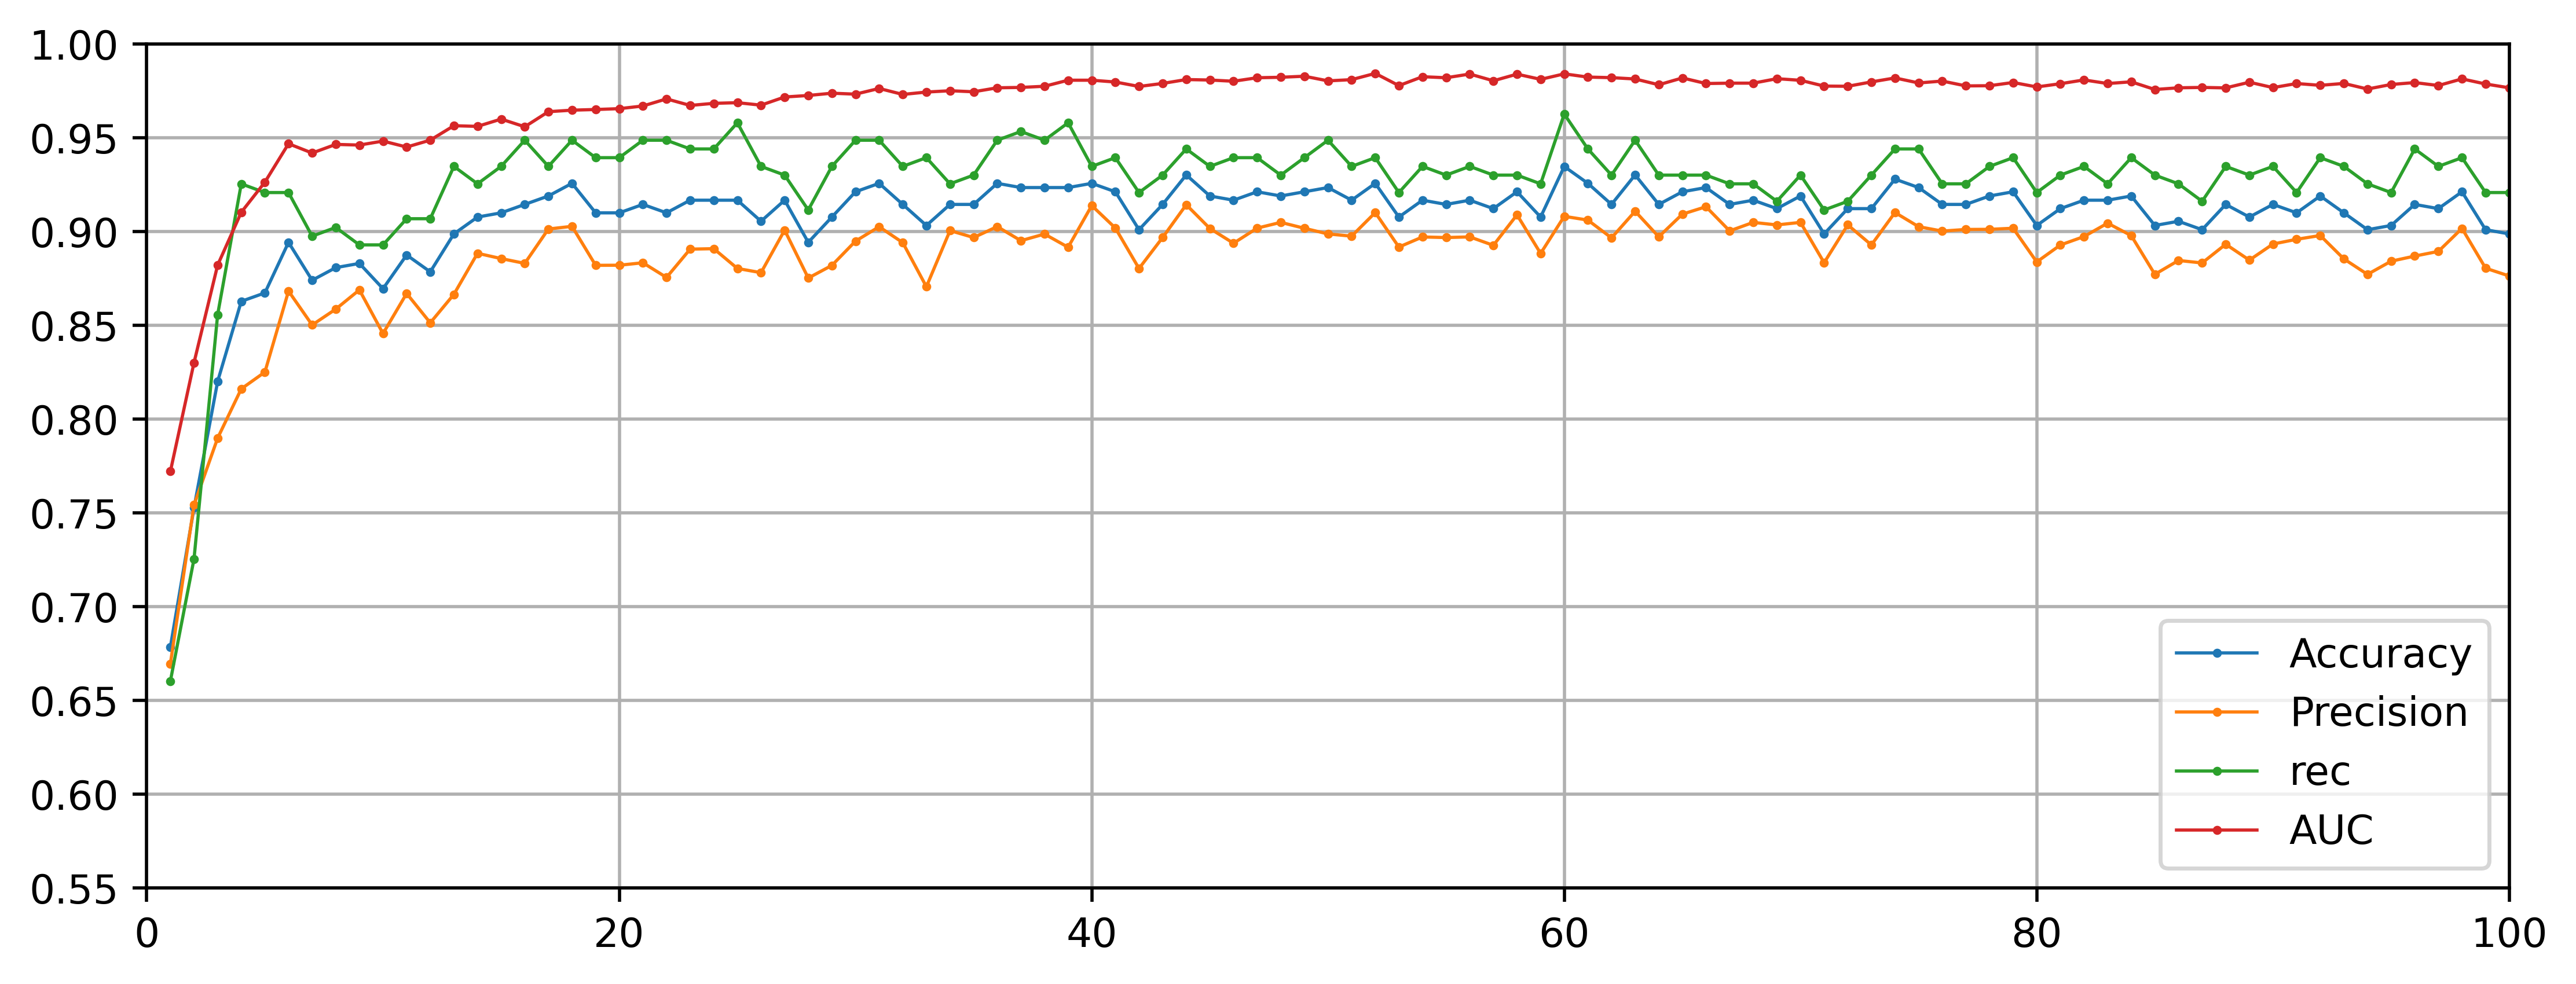

In [16]:
from matplotlib.pyplot import MultipleLocator

pointnum = bar
x_axi = geneNum[:pointnum]
plt.figure(figsize=(9, 3.5), dpi=500)
plt.xlim(0, pointnum, 50)
plt.ylim(0.55, 1)

markersize = 2.5
linewidth = 0.8

plt.plot(x_axi, acc[:pointnum], '.-',label='Accuracy', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, prec[:pointnum], '.-',label='Precision', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, rec[:pointnum], '.-',label='rec', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, auc[:pointnum], '.-',label='AUC', markersize= markersize, linewidth = linewidth)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

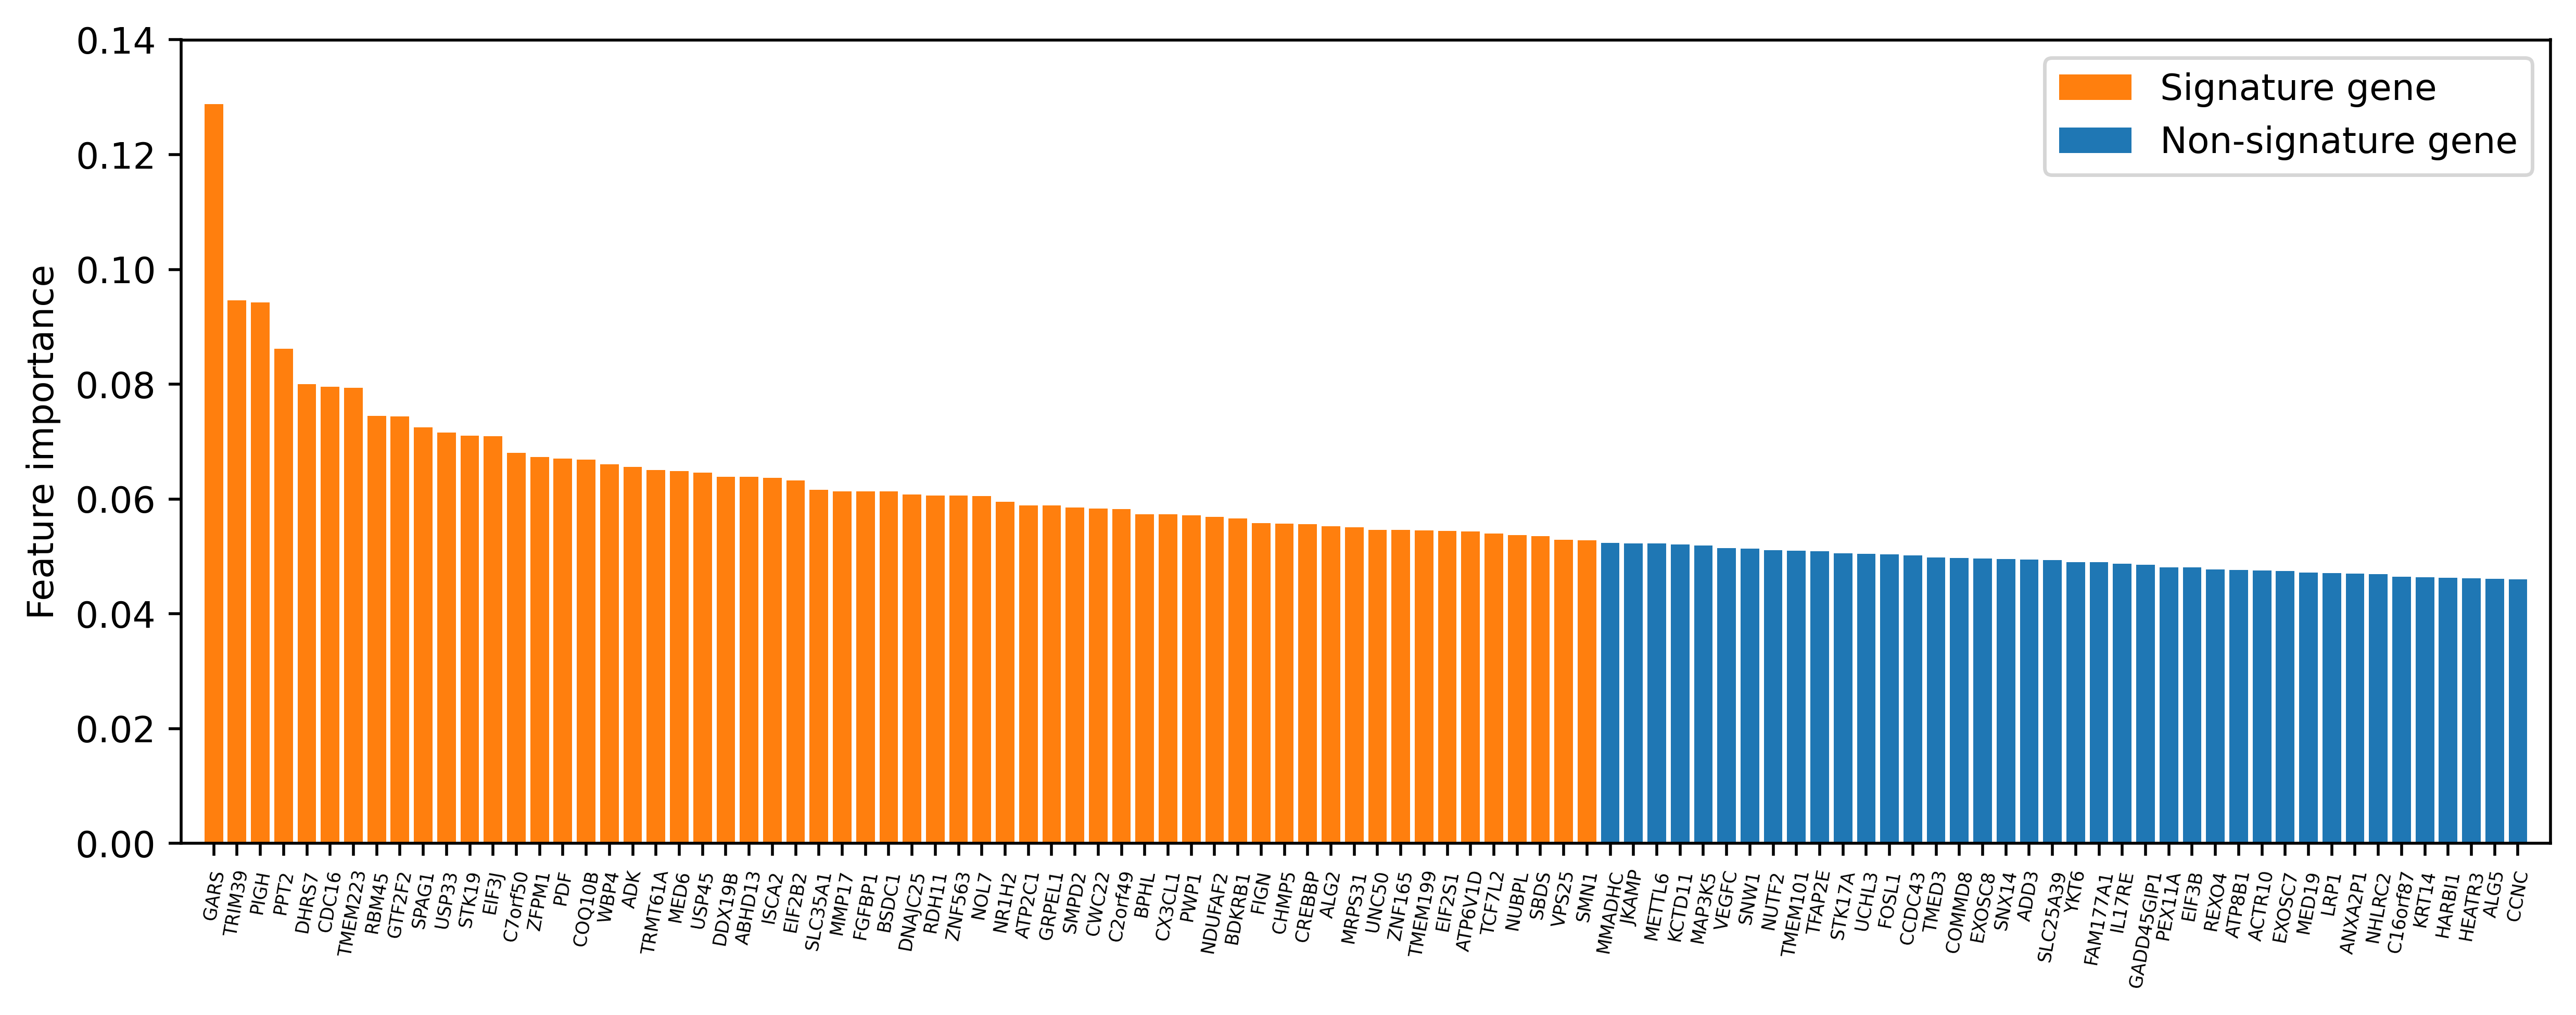

In [19]:
# Plot the sum of feature importance values for the top 100 genes.

SG = gene[sortedIdx][:SGnum]
SGimp = sortedImp[1, :SGnum]
left1 = np.arange(SGnum) + 1

nonSGnum = 40
nonSG = gene[sortedIdx][SGnum : SGnum + nonSGnum]
nonSGimp = sortedImp[1, SGnum : SGnum + nonSGnum]
left2 = np.arange(SGnum, SGnum + nonSGnum) + 1

fig = plt.figure(figsize=(10, 4), dpi=500)

ax = fig.add_subplot(111)

plt.bar(left2, nonSGimp, label = "Non-signature gene")
plt.bar(left1, SGimp, label = "Signature gene")  

locs, labs = plt.xticks(np.append(left1,left2), np.append(SG, nonSG), rotation=80, fontsize=5)

ax.set_ylim(0, 0.14)

plt.ylabel("Feature importance")
plt.margins(0.01)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]

ax.legend(handles,labels,loc='upper right')

plt.tight_layout()